# Download OPERA-CSLCs from ASF and Generate Interferogram

## A Minimal Example

Based on OPERA_Applications notebook: [Create_Interferogram_by_Streaming_CSLC-S1](https://github.com/OPERA-Cal-Val/OPERA_Applications/blob/main/CSLC/Discover/Create_Interferogram_by_Streaming_CSLC-S1.ipynb)

In [1]:
from getpass import getpass
import itertools
from pathlib import Path
import re

from ipyfilechooser import FileChooser

import h5py
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
import shapely.wkt as wkt

import asf_search as disco

**Select the directory holding you CSLCs**

In [2]:
print("Select the directory holding you CSLCs")
fc = FileChooser(Path.home())
display(fc)

Select the directory holding you CSLCs


FileChooser(path='/home/jovyan', filename='', title='', show_hidden=False, select_desc='Select', change_desc='…

In [5]:
cslc_dir = Path(fc.selected)
insar_dir = cslc_dir/"InSAR"
insar_dir.mkdir(exist_ok=True)

**Collect the paths to the CSLCs**

In [6]:
bursts = list(cslc_dir.glob('*.h5'))
bursts.sort()
bursts

[PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231027T132033Z_20231028T203147Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231108T132032Z_20231114T180748Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231120T132032Z_20231205T220247Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231202T132032Z_20231203T075751Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231202T132032Z_20231203T085133Z_S1A_VV_v1.0.h5')]

In [7]:
# When >1 CSLC are found for a burst/acquisition date, select the most recently processed

filtered_bursts = dict()
acquisition_date_regex = r"(?<=OPERA_L2_CSLC-S1_)T\d{3}-\d{6}-IW\d_\d{8}T\d{6}Z(?=_\d{8}T\d{6}Z)"
process_date_regex = '(?<=OPERA_L2_CSLC-S1_T\d{3}-\d{6}-IW\d_\d{8}T\d{6}Z_)\d{8}T\d{6}Z'

for b in bursts:
    try:
        id_date = re.search(acquisition_date_regex, str(b)).group(0)
        try:
            if filtered_bursts[id_date] < b:
                filtered_bursts[id_date] = b
        except KeyError:
            filtered_bursts[id_date] = b
    except AttributeError:
        raise Exception(f"Acquisition not found in filename: {str(b)}")
        
filtered_bursts = list(filtered_bursts.values())   
filtered_bursts

[PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231027T132033Z_20231028T203147Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231108T132032Z_20231114T180748Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231120T132032Z_20231205T220247Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231202T132032Z_20231203T085133Z_S1A_VV_v1.0.h5')]

In [8]:
stack = list(itertools.combinations(filtered_bursts, 2))
stack

[(PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
  PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231027T132033Z_20231028T203147Z_S1A_VV_v1.0.h5')),
 (PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
  PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231108T132032Z_20231114T180748Z_S1A_VV_v1.0.h5')),
 (PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
  PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231120T132032Z_20231205T220247Z_S1A_VV_v1.0.h5')),
 (PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231015T132033Z_20231016T163215Z_S1A_VV_v1.0.h5'),
  PosixPath('/home/jovyan/CSLC-test-4/OPERA_L2_CSLC-S1_T129-275817-IW3_20231202T132032Z_20231203T085133Z_S1A_VV_v1.0.h5')),
 (PosixPath(

**Create a list of CSLC acquisition dates**

In [ ]:
# date_regex = r"\d{8}T\d{6}Z(?=_\d{8}T\d{6}Z)"
# dates = []
# try:
#     for b in bursts:
#         dates.append(re.search(date_regex, str(b)).group(0))
#     dates = [d[:8] for d in dates]
#     print(dates)  
# except AttributeError:
#     raise Exception(f"Date string not found in {b}") 

In [9]:
# Convert each pixel to RGB, adjusting colorscale relative to data range
def colorize(array=[], cmap='RdBu', cmin=[], cmax=[]):
    normed_data = (array - cmin) / (cmax - cmin)    
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data) 

**Generate the interferogram**

['20231015', '20231027']


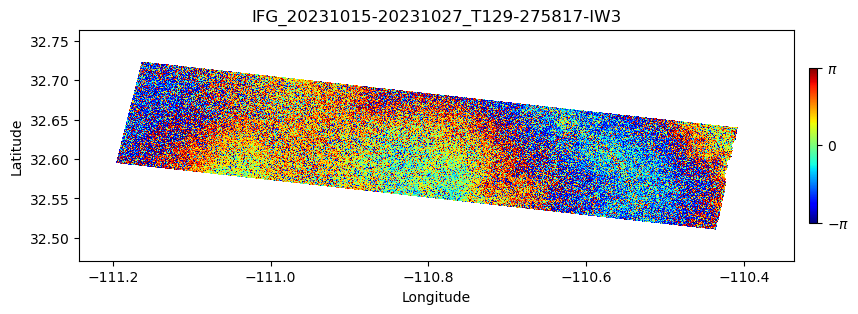

['20231015', '20231108']


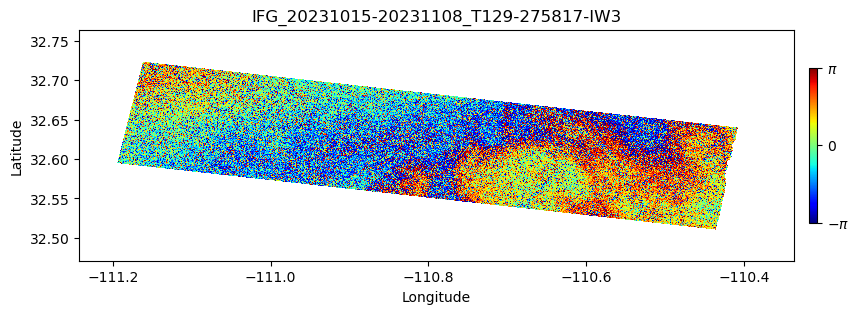

['20231015', '20231120']


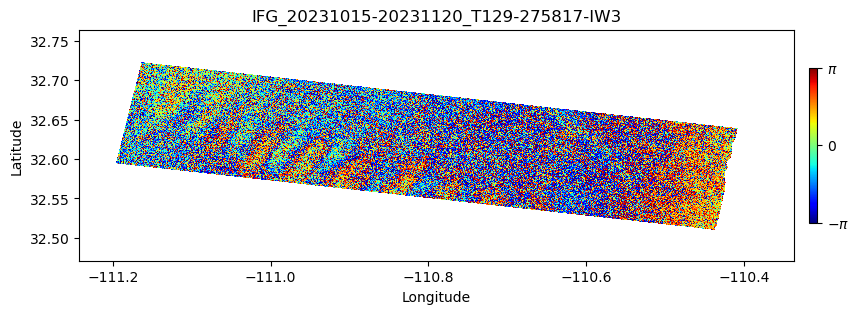

['20231015', '20231202']


In [ ]:
for pair in stack:

    # Get the burst ID
    burst_id_regex = r'(?<=OPERA_L2_CSLC-S1_)T\d{3}-\d{6}-IW\d'
    try:
        burst_id = re.search(burst_id_regex, str(pair[0])).group(0)
    except AttributeError:
        raise Exception(f"Burst ID not found in {str(pair[0])}") 

    date_regex = r"\d{8}T\d{6}Z(?=_\d{8}T\d{6}Z)"
    dates = []
    try:
        for b in pair:
            dates.append(re.search(date_regex, str(b)).group(0))
        dates = [d[:8] for d in dates]
        print(dates)  
    except AttributeError:
        raise Exception(f"Date string not found in {b}") 
        
    # Load the reference CSLC and gather needed metadata
    with h5py.File(pair[0], 'r') as h5:    
        grid_path = f'data'
        cslc_0 = h5[f'{grid_path}/VV'][:]    

        id_path = f'identification'
        bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
        cslc_poly = wkt.loads(bounding_polygon)
        bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

        xcoor = h5[f'{grid_path}/x_coordinates'][:]
        ycoor = h5[f'{grid_path}/y_coordinates'][:]    
        dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
        dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
        transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
        epsg = h5[f'{grid_path}/projection'][()].astype(int)

    # Load the secondary CSLC
    with h5py.File(pair[1], 'r') as h5:    
        grid_path = f'data'
        cslc_1 = h5[f'{grid_path}/VV'][:]

    # Calculate interferogram
    ifg = cslc_0 * np.conj(cslc_1)

    # Plot each interferogram
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    cbar.set_ticks([-np.pi, 0., np.pi])
    cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    title = f'IFG_{dates[0]}-{dates[1]}_{burst_id}'
    ax.set_title(title,fontsize=12)
    plt.show()

    ifg_ang = np.angle(ifg)
    ds = rasterio.open(insar_dir/f'{title}.tif', 'w', driver='GTiff',
                       height = ifg_ang.shape[0], 
                       width = ifg_ang.shape[1],
                       count=1, 
                       dtype=rasterio.float32,
                       crs=CRS.from_epsg(epsg),
                       transform=transform,nodata=np.nan)
    ds.write(ifg_ang, 1)
    ds.close()

In [ ]:
# Get the burst ID
burst_id_regex = r'(?<=OPERA_L2_CSLC-S1_)T\d{3}-\d{6}-IW\d'
try:
    burst_id = re.search(burst_id_regex, str(bursts[0])).group(0)
except AttributeError:
    raise Exception(f"Burst ID not found in {str(bursts[0])}") 

# Load the reference CSLC and gather needed metadata
with h5py.File(bursts[0], 'r') as h5:    
    grid_path = f'data'
    cslc_0 = h5[f'{grid_path}/VV'][:]    
    
    id_path = f'identification'
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]
    
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]    
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    
# Load the secondary CSLC
with h5py.File(bursts[1], 'r') as h5:    
    grid_path = f'data'
    cslc_1 = h5[f'{grid_path}/VV'][:]

# Calculate interferogram
ifg = cslc_0 * np.conj(cslc_1)

**Plot the interferogram**

In [ ]:
# Convert each pixel to RGB, adjusting colorscale relative to data range
def colorize(array=[], cmap='RdBu', cmin=[], cmax=[]):
    normed_data = (array - cmin) / (cmax - cmin)    
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data) 

# Plot each interferogram
fig, ax = plt.subplots(figsize=(10,3))
cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
cbar.set_ticks([-np.pi, 0., np.pi])
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
title = f'IFG_{dates[1]}-{dates[0]}_{burst_id}'
ax.set_title(title,fontsize=12)

**Write the interferogram to GeoTiff**

In [ ]:
ifg_ang = np.angle(ifg)
ds = rasterio.open(insar_dir/f'{title}.tif', 'w', driver='GTiff',
                   height = ifg_ang.shape[0], 
                   width = ifg_ang.shape[1],
                   count=1, 
                   dtype=rasterio.float32,
                   crs=CRS.from_epsg(epsg),
                   transform=transform,nodata=np.nan)
ds.write(ifg_ang, 1)
ds.close()